In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor,export_text, export_graphviz, plot_tree
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.inspection import PartialDependenceDisplay
import mpl_toolkits.mplot3d
from sklearn.inspection import partial_dependence, permutation_importance
from pdpbox import pdp, info_plots

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [4]:
# Boston 数据集
Boston = pd.DataFrame(pd.read_excel('/Users/zhuolinli/Downloads/house_data.xlsx', header=0))
data = Boston.iloc[:,:13]
target = Boston['MEDV']

In [5]:
# 设定训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=1)

In [6]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


#  决策树建模

In [7]:
# 实例化模型与回归
model = DecisionTreeRegressor(max_depth=2, random_state=123)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=123)

In [8]:
# 测试集拟合优度
model.score(X_test, y_test)

0.720452737210959

In [9]:
print(export_text(model, feature_names=list(data.columns)))

|--- LSTAT <= 9.55
|   |--- RM <= 7.43
|   |   |--- value: [27.67]
|   |--- RM >  7.43
|   |   |--- value: [44.30]
|--- LSTAT >  9.55
|   |--- LSTAT <= 19.26
|   |   |--- value: [19.44]
|   |--- LSTAT >  19.26
|   |   |--- value: [12.75]



[Text(0.5, 0.8333333333333334, 'LSTAT <= 9.545\nsquared_error = 81.189\nsamples = 354\nvalue = 22.34'),
 Text(0.25, 0.5, 'RM <= 7.435\nsquared_error = 78.714\nsamples = 136\nvalue = 29.99'),
 Text(0.125, 0.16666666666666666, 'squared_error = 45.062\nsamples = 117\nvalue = 27.666'),
 Text(0.375, 0.16666666666666666, 'squared_error = 47.9\nsamples = 19\nvalue = 44.3'),
 Text(0.75, 0.5, 'LSTAT <= 19.26\nsquared_error = 23.449\nsamples = 218\nvalue = 17.567'),
 Text(0.625, 0.16666666666666666, 'squared_error = 12.711\nsamples = 157\nvalue = 19.44'),
 Text(0.875, 0.16666666666666666, 'squared_error = 18.829\nsamples = 61\nvalue = 12.748')]

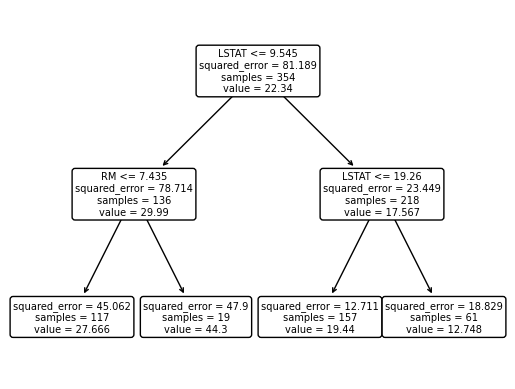

In [11]:
# 决策树模型可视化 - plot_tree 方法
plot_tree(model, feature_names=list(data.columns), node_ids=False, rounded=True, precision=3)

In [12]:
# 决策树模型可视化 - 基于 graphviz 包
export_graphviz(model, out_file='/Users/zhuolinli/Desktop/DTree.dot',
               feature_names=data.columns, class_names=target,
               filled=True, leaves_parallel=True, rounded=True, precision=2)
# 可视化展示 - 终端输入
# dot DTree.dot -T png -o DTree.png

Text(0.5, 1.0, 'Total Leaf MES vs. alphafor training Set')

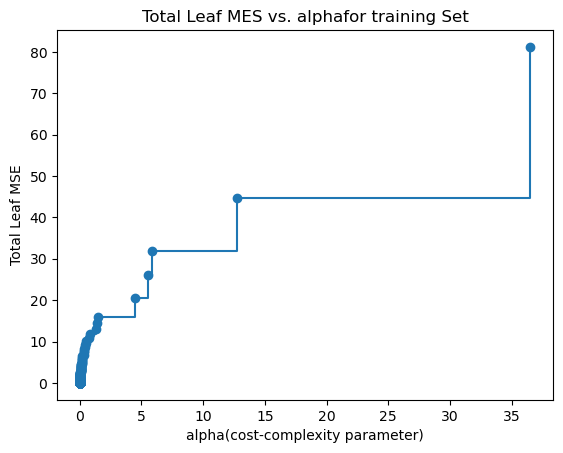

In [13]:
"""
后剪枝策略的应用
"""
clf = DecisionTreeRegressor(random_state=123)
ccp_path = clf.cost_complexity_pruning_path(X_train, y_train)
# 绘图展示
plt.plot(ccp_path.ccp_alphas, ccp_path.impurities, marker='o', drawstyle='steps-post')
plt.xlabel('alpha(cost-complexity parameter)')
plt.ylabel('Total Leaf MSE')
plt.title('Total Leaf MES vs. alphafor training Set')

In [14]:
# K-Fold交叉验证选取最优模型
param_grid = {'ccp_alpha':ccp_path.ccp_alphas}
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
cvmodel = GridSearchCV(DecisionTreeRegressor(random_state=123), param_grid, cv=kfold)
cvmodel.fit(X_train, y_train)
cvmodel.best_params_

{'ccp_alpha': 0.22721319836786386}

In [15]:
best_model = cvmodel.best_estimator_
best_model.score(X_test, y_test)

0.8781840129042634

In [16]:
# 决策树模型可视化 - 基于 graphviz 包
export_graphviz(best_model, out_file='/Users/zhuolinli/Desktop/DTree.dot',
               feature_names=data.columns, class_names=target,
               filled=True, leaves_parallel=True, rounded=True, precision=2)
# 可视化展示 - 终端输入
# dot DTree.dot -T png -o DTree.png

In [17]:
# 决策树深度
best_model.get_depth()

7

In [18]:
# 决策树叶节点数量
best_model.get_n_leaves()

22

In [19]:
# 计算每个变量的重要性
best_model.feature_importances_

array([0.01613427, 0.        , 0.        , 0.        , 0.04164118,
       0.26443614, 0.        , 0.07761705, 0.0047791 , 0.0052992 ,
       0.00567497, 0.        , 0.58441809])

In [20]:
data.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

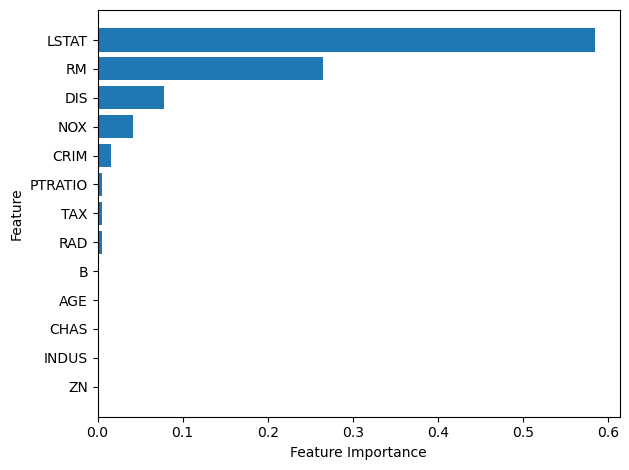

In [21]:
# 绘制变量重要性柱状图
sorted_index = best_model.feature_importances_.argsort()
plt.barh(range(data.shape[1]), best_model.feature_importances_[sorted_index])
plt.yticks(np.arange(data.shape[1]), data.columns[sorted_index])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()

In [22]:
# 在测试集中进行预测
pred = best_model.predict(X_test)

Text(0.5, 1.0, 'Tree Prediction')

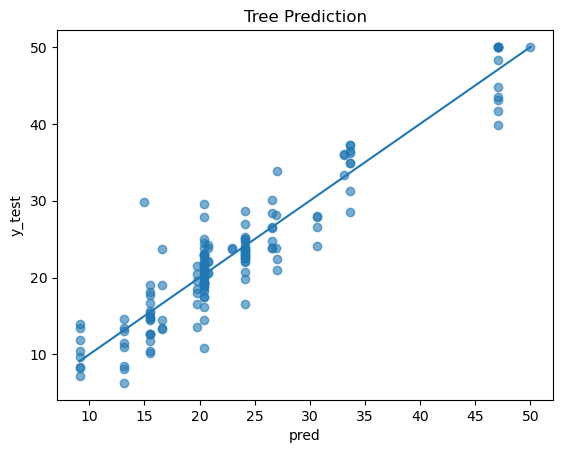

In [23]:
# 绘图查看
plt.scatter(pred, y_test, alpha=0.6)
w = np.linspace(min(pred), max(pred))
plt.plot(w, w)
plt.xlabel('pred')
plt.ylabel('y_test')
plt.title('Tree Prediction')

#  随机森林

In [24]:
# 实例化与回归
BagModel = BaggingRegressor(
    estimator=DecisionTreeRegressor(random_state=123),
    n_estimators=500,
    oob_score=True,
    random_state=0
)
BagModel.fit(X_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(random_state=123),
                 n_estimators=500, oob_score=True, random_state=0)

In [25]:
# 计算袋外均方误MSE
oob_mse = mean_squared_error(y_train, BagModel.oob_prediction_)

In [26]:
# 袋外预测值拟合优度
oob_rsq = BagModel.oob_score_
oob_rsq

0.8603578220856694

Text(0.5, 1.0, 'Bagging OOB ERROR')

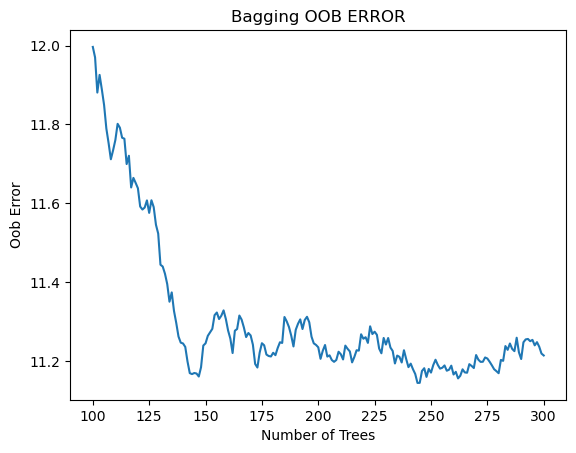

In [27]:
"""
考察决策树数目对袋外误差的影响
"""
oob_errors = []
for N in range(100, 301):
    B_model = BaggingRegressor(estimator=DecisionTreeRegressor(random_state=123),
                              n_estimators=N, n_jobs=-1,
                              oob_score=True, random_state=0)
    B_model.fit(X_train, y_train)
    pred_oob = B_model.oob_prediction_
    oob_errors.append(mean_squared_error(y_train, pred_oob))
plt.plot(range(100, 301), oob_errors)
plt.xlabel('Number of Trees')
plt.ylabel('Oob Error')
plt.title('Bagging OOB ERROR')

#  RF

In [28]:
max_feature = int(X_train.shape[1] / 3)  # mtry参数

In [29]:
# 实例化与回归
clf = RandomForestRegressor(n_estimators=500,
                           max_features=max_feature,
                           random_state=0)
clf.fit(X_train, y_train)

RandomForestRegressor(max_features=4, n_estimators=500, random_state=0)

In [30]:
clf.score(X_test, y_test)

0.8970775472302749

In [31]:
pred = clf.predict(X_test)

Text(0.5, 1.0, 'Random Forest Prediction')

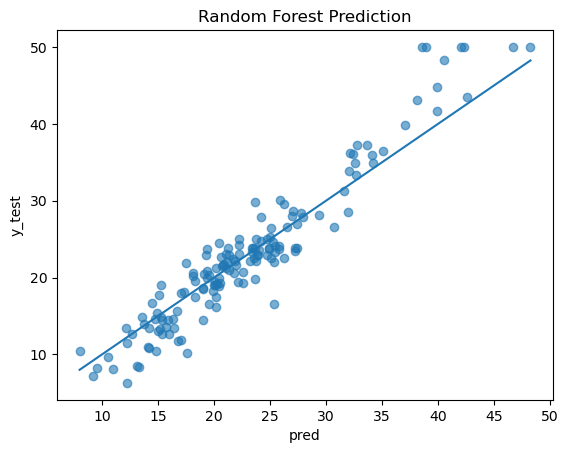

In [32]:
# 预测结果绘图
plt.scatter(pred, y_test, alpha=0.6)
w = np.linspace(min(pred), max(pred), 100)
plt.plot(w, w)
plt.xlabel('pred')
plt.ylabel('y_test')
plt.title('Random Forest Prediction')

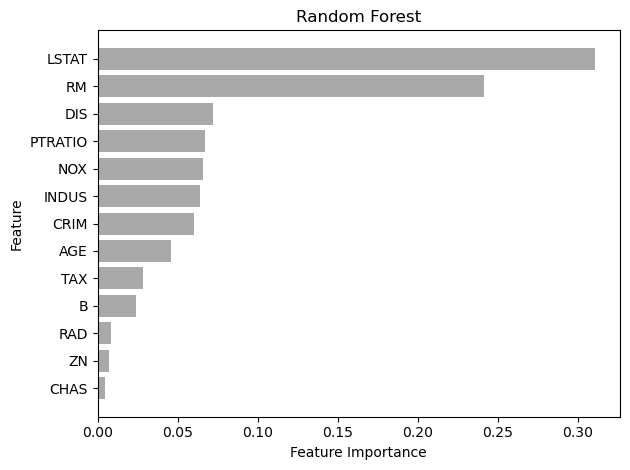

In [33]:
# 特征重要性图
clf.feature_importances_
sorted_index = clf.feature_importances_.argsort()
plt.barh(range(data.shape[1]), clf.feature_importances_[sorted_index], color='darkgray')
plt.yticks(np.arange(data.shape[1]), data.columns[sorted_index])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest')
plt.tight_layout()

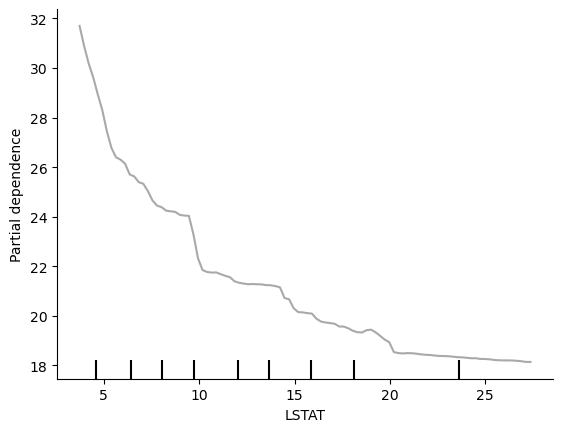

In [34]:
# 绘制偏依赖图（PDP）
a = PartialDependenceDisplay.from_estimator(clf, X_train, features=['LSTAT'],
                                            line_kw={"color": "darkgray"}, n_jobs=-1)
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

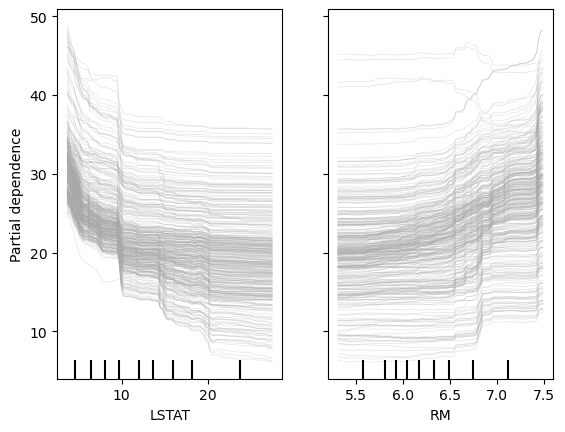

In [35]:
# 绘制个人条件期望图（ICE）
PartialDependenceDisplay.from_estimator(clf, X_train, features=['LSTAT', 'RM'], kind='individual',line_kw={"color": "darkgray"}, n_jobs=-1)

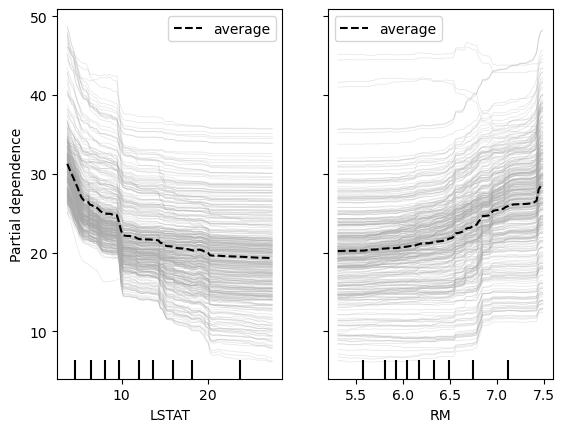

In [36]:
# PDP & ICE 同时绘制
PartialDependenceDisplay.from_estimator(clf, X_train, features=['LSTAT', 'RM'],
                                        kind='both',
                                        ice_lines_kw={"color": "darkgray"},
                                        pd_line_kw={"color": "k"},
                                        n_jobs=-1)

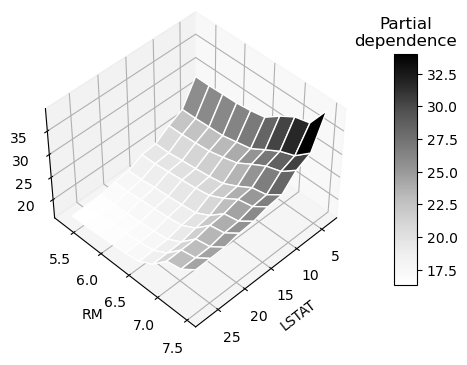

In [37]:
# 3D部分依赖图
import mpl_toolkits.mplot3d
import numpy as np

from sklearn.inspection import partial_dependence

fig = plt.figure(figsize=(5.5, 5))

features = ["LSTAT", "RM"]
pdp = partial_dependence(
    clf, X_train, features=features, kind="average", grid_resolution=10
)
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = fig.add_subplot(projection="3d")
fig.add_axes(ax)

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.Greys, edgecolor="w")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
fig.suptitle(
    None,
    fontsize=16,
)


ax.view_init(elev=45, azim=45)
clb = plt.colorbar(surf, pad=0.1, shrink=0.6, aspect=10)
clb.ax.set_title("Partial\ndependence")
plt.show()

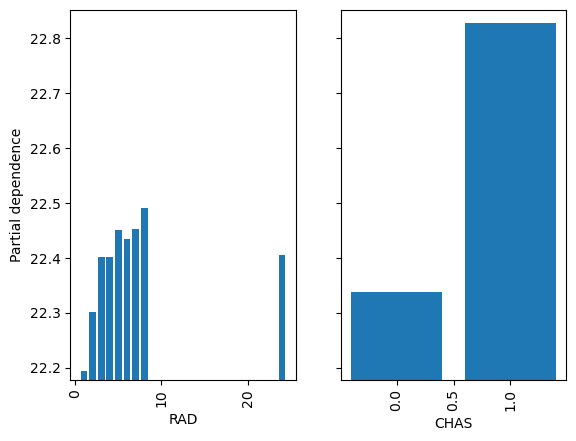

In [38]:
categorical_features = ["RAD", "CHAS"]
common_params = {
    "subsample": 50,
    "n_jobs": -1,
    "grid_resolution": 20,
    "random_state": 0,
}

features_info = {
    # features of interest
    "features": ["RAD", "CHAS"],
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": categorical_features,
}

# _, ax = plt.subplots(ncols=2, nrows=1, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    clf,
    X_train,
    **features_info,
#     ax=ax,
    **common_params,
)

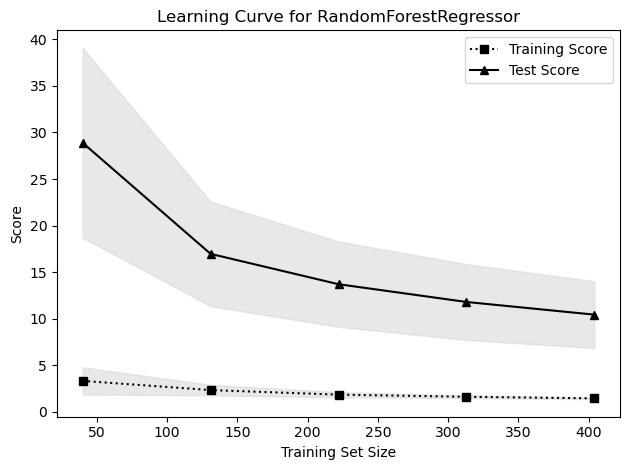

In [39]:
# 学习曲线图 绘制
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

X = data
y = target
_, ax = plt.subplots()
common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "scoring": "neg_mean_squared_error",
    "negate_score": True,
    "n_jobs": 3,
    "line_kw": {"marker": "^", "color": "k"},
    "fill_between_kw":{"color":"lightgray"},
    "std_display_style": "fill_between",
    "score_name": "mean_squared_error",
}

a = LearningCurveDisplay.from_estimator(estimator=clf, **common_params, ax=ax)
line1, line2 = ax.get_lines()
line1.set_linestyle('dotted')
line1.set_marker("s")
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
plt.title(f"Learning Curve for {clf.__class__.__name__}")
plt.xlabel("Training Set Size"), plt.ylabel("Score")
plt.tight_layout()

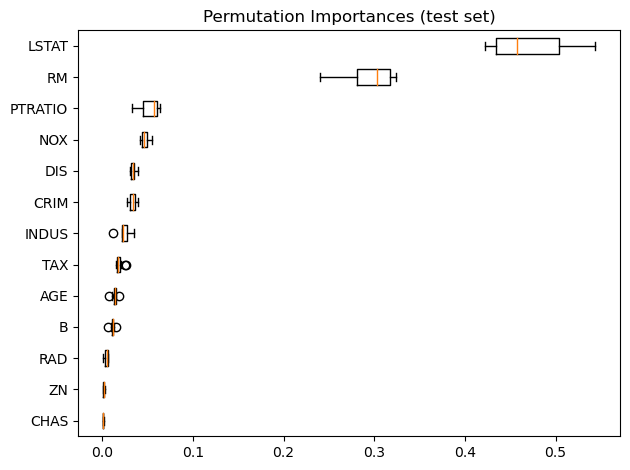

In [40]:
# 排列重要性图
result = permutation_importance(clf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [41]:
shap_values = shap.TreeExplainer(clf).shap_values(X_train)

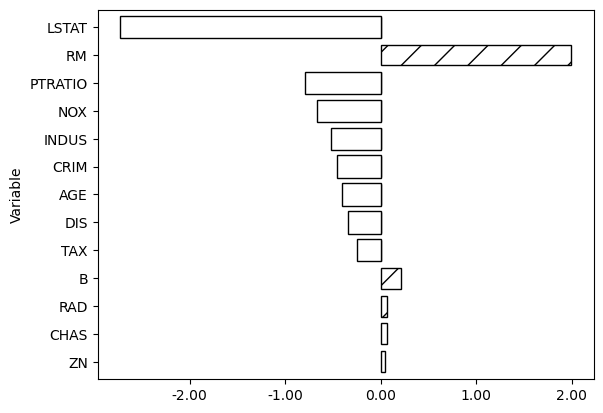

In [42]:
# 沙普利值 变量重要性 绘图
import matplotlib.ticker as mtick
def ABS_SHAP(df_shap, df):
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)

    # 求SHAP值与data的相关系数，判断正负影响
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'/','')

    # Plot
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2_ = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2_ = k2_.sort_values(by='SHAP_abs',ascending = True)
    k2 = np.around(k2_, 4)
    k3 = k2.copy()
    k3.loc[k3['Sign']=='/', 'SHAP_abs'] = np.nan  # k3仅包含负shap值
    k4 = k2.copy()
    k4.loc[k4['Sign']=='', 'SHAP_abs'] = np.nan  # k4仅包含正shap值
    k3['SHAP_abs'] = -k3['SHAP_abs']
    hatch_lst = k2['Sign']
    ax = k4.plot.barh(x='Variable',y='SHAP_abs',
                      color='w', edgecolor="k",width=0.75, hatch=hatch_lst, legend=False)
    plt.barh(k3['Variable'], k3['SHAP_abs'], color='w', edgecolor="k", hatch=hatch_lst)
    
    ax=plt.gca()
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    
    
ABS_SHAP(shap_values, X_train)

In [43]:
cols = [i for i in Boston.columns]
cols.remove('MEDV')
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(Boston[cols])

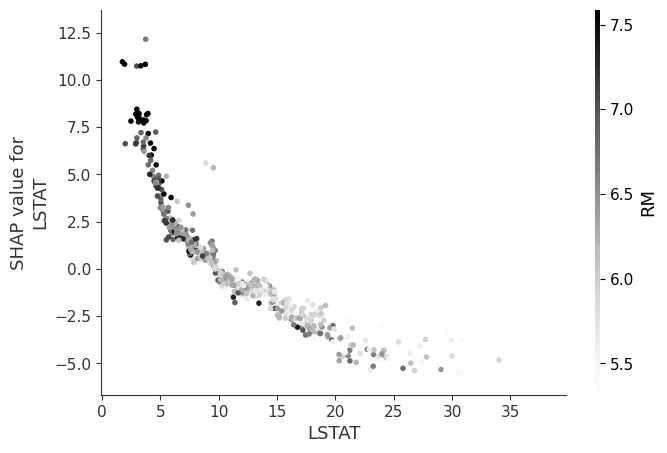

In [44]:
for i in ['RM']:
    shap.dependence_plot('LSTAT', shap_values, Boston[cols], interaction_index=i, cmap=plt.get_cmap("Greys"))

In [45]:
"""
不推荐的方法，仅做展示
"""
# 通过测试集选择最优mtry
scores = []
for max_features in range(1, data.shape[1] + 1):
    model = RandomForestRegressor(max_features=max_features,
                                 n_estimators = 500, random_state=123, n_jobs=-1)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    scores.append(score)

index = np.argmax(scores)  # return 最大值的索引
range(1, data.shape[1]+1)[index]

9

Text(0.5, 1.0, 'Choose max_features via Test Set')

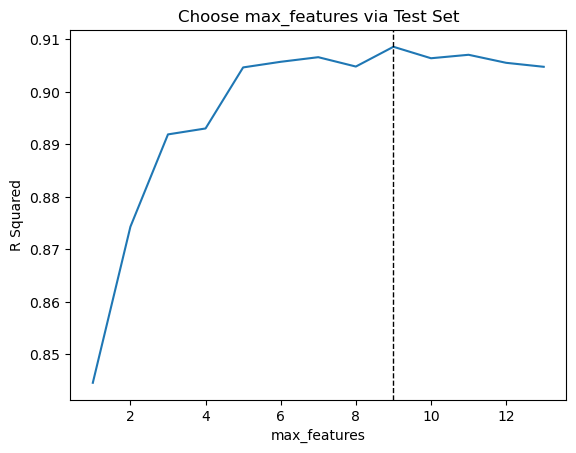

In [46]:
# 绘图展示
plt.plot(range(1, data.shape[1]+1), scores)
plt.axvline(range(1, data.shape[1]+1)[index], linestyle='--', color='k', linewidth=1)
plt.xlabel('max_features')
plt.ylabel('R Squared')
plt.title('Choose max_features via Test Set')

In [47]:
"""
推荐的选择超参数mtry的方法：交叉验证法
"""
max_feat = range(1, data.shape[1] + 1)
param_grid = {'max_features':max_feat}
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
best_model = GridSearchCV(RandomForestRegressor(n_estimators=300, random_state=123, n_jobs=-1),
                         param_grid, cv=kfold,
                         scoring='neg_mean_squared_error',
                         return_train_score=True, n_jobs=-1)
best_model.fit(X_train, y_train)
best_model.best_params_

{'max_features': 7}

In [48]:
cv_mse = -best_model.cv_results_['mean_test_score']

Text(0.5, 1.0, 'CV ERROR FOR RF')

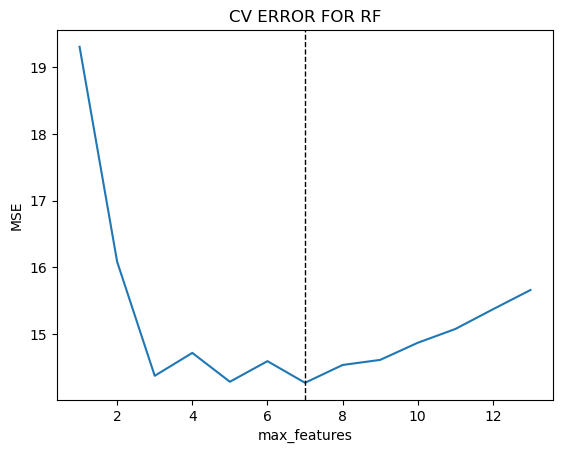

In [49]:
# 绘制交叉验证图
plt.plot(max_feat, cv_mse)
plt.axvline(max_feat[np.argmin(cv_mse)], linestyle='--', color='k', linewidth=1)
plt.xlabel('max_features')
plt.ylabel('MSE')
plt.title('CV ERROR FOR RF')

#   回归提升树

In [50]:
GradBoost = GradientBoostingRegressor(random_state=123)
GradBoost.fit(X_train, y_train)

GradientBoostingRegressor(random_state=123)

In [51]:
GradBoost.score(X_test, y_test)

0.9214598819200858

In [52]:
# 在超参数分布空间进行随机搜索
param_distributions = {'n_estimators':range(1, 300),
                      'max_depth':range(1, 10),
                      'subsample': np.linspace(0.1, 1, 10),
                      'learning_rate': np.linspace(0.1, 1, 10)}
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
best_model = RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=123),
                               param_distributions=param_distributions,
                               n_iter=100, random_state=0, n_jobs=-1)
best_model.fit(X_train, y_train)

RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=123),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'max_depth': range(1, 10),
                                        'n_estimators': range(1, 300),
                                        'subsample': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=0)

In [53]:
best_model.best_params_

{'subsample': 0.8, 'n_estimators': 190, 'max_depth': 3, 'learning_rate': 0.1}

In [54]:
best_model = best_model.best_estimator_
best_model.score(X_test, y_test)

0.9174111738345988

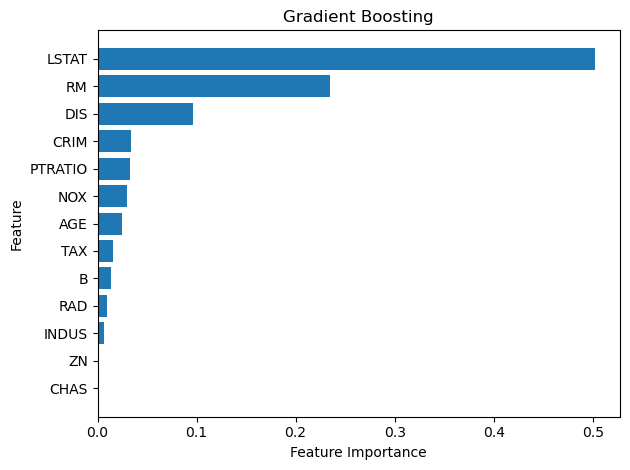

In [55]:
# 变量重要性
sorted_index = best_model.feature_importances_.argsort()
plt.barh(range(data.shape[1]), best_model.feature_importances_[sorted_index])
plt.yticks(np.arange(data.shape[1]), data.columns[sorted_index])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Gradient Boosting')
plt.tight_layout()

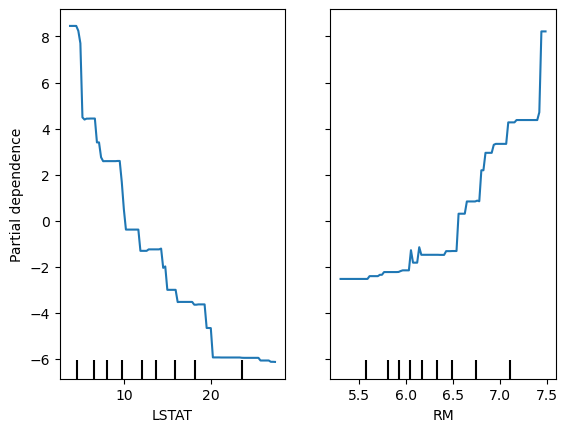

In [56]:
PartialDependenceDisplay.from_estimator(GradBoost, X_train, features=['LSTAT', 'RM'])

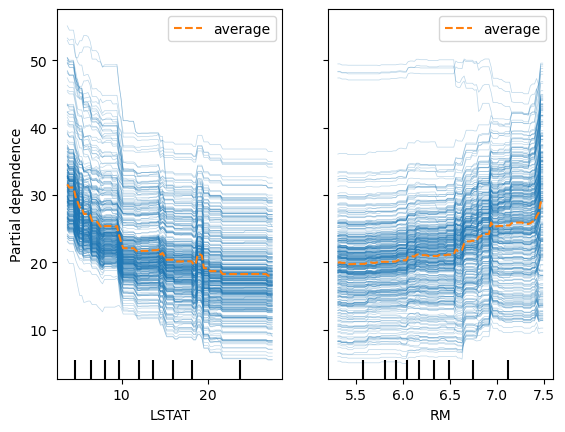

In [57]:
# PDP & ICE 组合图
PartialDependenceDisplay.from_estimator(best_model, X_train, features=['LSTAT', 'RM'], kind='both', n_jobs=-1)

In [58]:
# 考察决策树数量是否导致过拟合
scores = []
for n_estimators in range(1, 301):
    model = GradientBoostingRegressor(n_estimators=n_estimators, subsample=0.5,
                                     max_depth=5, learning_rate=0.1, random_state=123)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    scores.append(mse)
    
index = np.argmin(scores)
range(1, 301)[index]

53

Text(0.5, 1.0, 'MSE on Test Set')

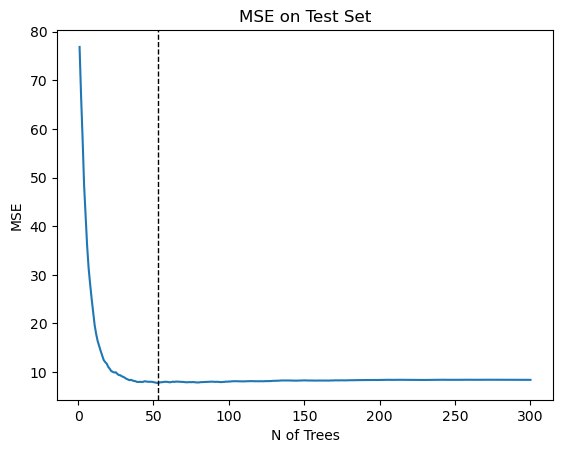

In [59]:
plt.plot(range(1, 301), scores)
plt.axvline(range(1, 301)[index], linestyle='--',
           color='k', linewidth=1)
plt.xlabel('N of Trees')
plt.ylabel('MSE')
plt.title('MSE on Test Set')

In [60]:
"""
xgboost建模
"""
model = xgb.XGBRegressor(objective='reg:squarederror',
                        n_estimators=300, max_depth=6, 
                        subsample=0.6, colsample_bytree=0.8, learning_rate=0.1,
                        random_state=0)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [61]:
model.score(X_test, y_test)

0.9027337476066284

In [62]:
pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
rmse  # 均方根误差

2.9857810494791392

In [63]:
# 交叉验证
params = {'objective':'reg:squarederror',
          'max_depth':6, 'subsample':0.6,
          'colsample_bytree':0.8,
          'learning_rate':0.1}
dtrain = xgb.DMatrix(data=X_train, label=y_train)

results = xgb.cv(dtrain=dtrain,
                 params=params,
                 nfold=10,
                 metrics='rmse',
                 num_boost_round=300,
                 as_pandas=True,
                 seed=123)

In [64]:
results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
295,0.028927,0.004504,3.322741,0.654408
296,0.028470,0.004440,3.322575,0.654508
297,0.028025,0.004344,3.322525,0.654666
298,0.027648,0.004340,3.322430,0.654640
299,0.027280,0.004264,3.322410,0.654692


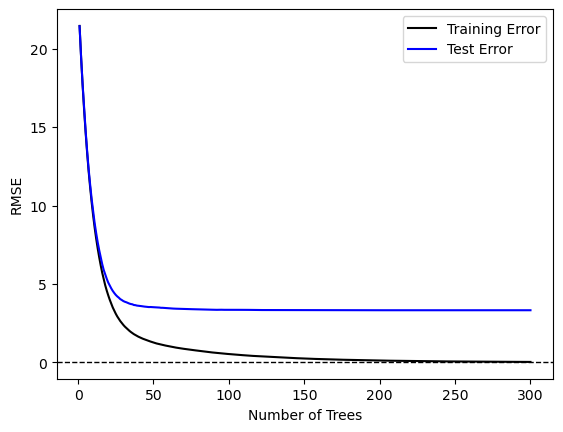

In [66]:
# 绘图展示
plt.plot(range(1, 301), results['train-rmse-mean'], 'k', label='Training Error')
plt.plot(range(1, 301), results['test-rmse-mean'], 'b', label='Test Error')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.axhline(0, linestyle='--', color='k', linewidth=1)
plt.legend()